In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import pandas as pd

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np 
from typing import List, Tuple
from flwr.common import Metrics
#https://medium.com/mlearning-ai/evaluating-federated-learning-from-felt-labs-on-mnist-dataset-cbe081b28786


# Data Processing

In [2]:
def getMnistData():
    (traindataset,testDataset),datasetinfo = tfds.load(
        'cifar10',
        split=['train','test'],
        shuffle_files= True,
        as_supervised= True,
        with_info= True
    )
    return traindataset,testDataset,datasetinfo

In [3]:
def dataset_to_numpy(dataset):
    features = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        features.append(image)
        labels.append(label)
    return np.array(features), np.array(labels)

def Splitset(intrain,intest):
    Train_images, Train_label = dataset_to_numpy(intrain)
    Test_images, Test_label = dataset_to_numpy(intest)
    return  Train_images, Train_label,Test_images, Test_label

def datanorm(data):
    return data/255 

In [4]:
trainset,testset, info = getMnistData()
Train_images, Train_label,Test_images, Test_label = Splitset(trainset,testset)
Train_images_n = datanorm(Train_images)
Test_images_n = datanorm(Test_images)


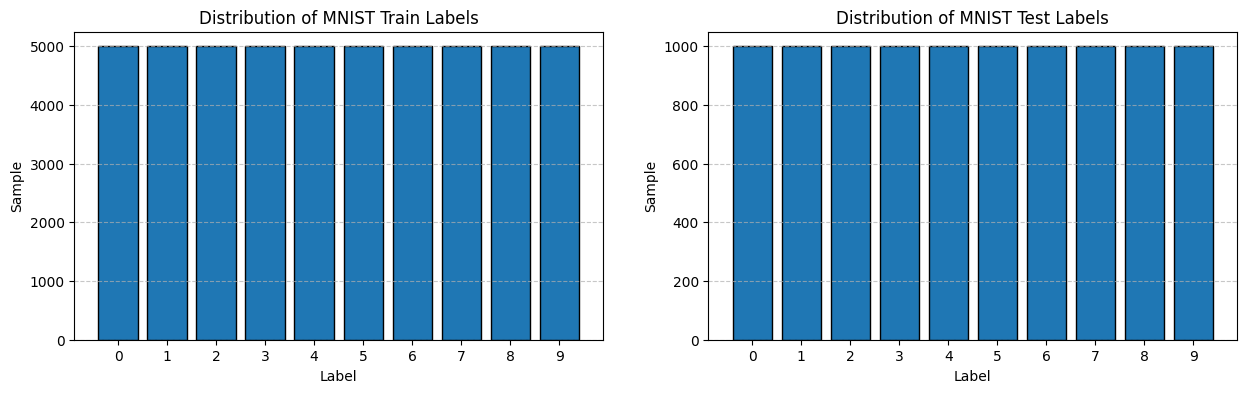

In [5]:
fig_1,axs_1 = plt.subplots(1,2,figsize = (15,4))
axs_1[0].hist(Train_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[0].set_title('Distribution of MNIST Train Labels')
axs_1[0].set_xlabel('Label')
axs_1[0].set_ylabel('Sample')
axs_1[0].set_xticks(range(10))  # Digits 0 to 9
axs_1[0].grid(axis='y', linestyle='--', alpha=0.7)

axs_1[1].hist(Test_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[1].set_title('Distribution of MNIST Test Labels')
axs_1[1].set_xlabel('Label')
axs_1[1].set_ylabel('Sample')
axs_1[1].set_xticks(range(10))  # Digits 0 to 9
axs_1[1].grid(axis='y', linestyle='--', alpha=0.7)


# Partition DataSet

In [6]:
def split_intoPartition(data, num_partitions):
    # Calculate the size of each partition
    partition_size = len(data) // num_partitions
    # Split the dataset into partitions
    partitions = [data[i * partition_size:(i + 1) * partition_size] for i in range(num_partitions)]
    return partitions    

In [7]:
NumOfPartition = 2
train_image_part = split_intoPartition(Train_images_n,NumOfPartition)
train_label_part = split_intoPartition(Train_label,NumOfPartition)

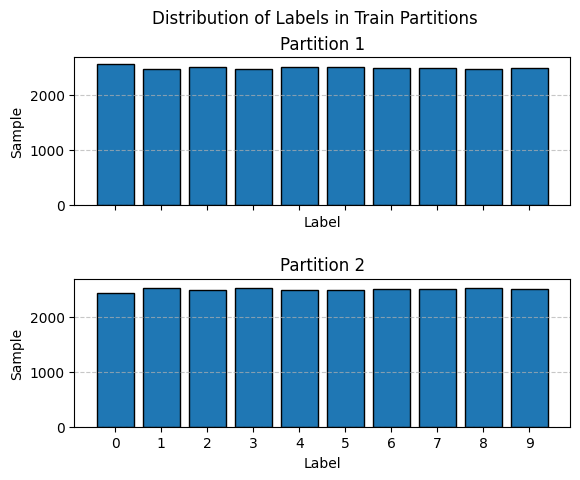

In [8]:
# Plot histogram for each partition
fig, axs = plt.subplots(NumOfPartition, sharex=True, sharey=True)

for i, partition in enumerate(train_label_part):
    axs[i].hist(partition, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black')
    axs[i].set_title(f'Partition {i + 1}')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Sample')
    axs[i].set_xticks(range(10))
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Labels in Train Partitions')
plt.show()

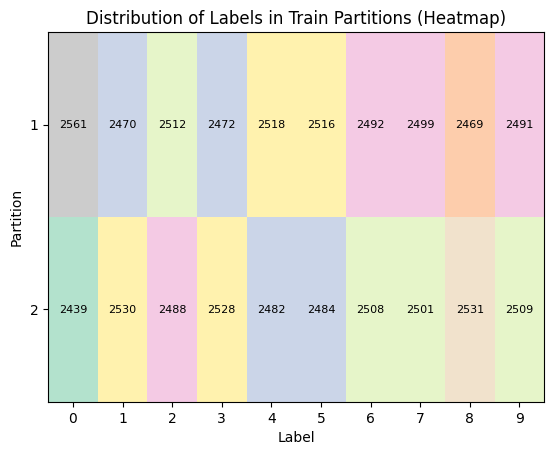

In [9]:
# Create an array to store the histogram data for each partition
hist_data = [np.histogram(partition, bins=range(11))[0] for partition in train_label_part]

# Plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(hist_data, cmap='Pastel2',aspect='auto', interpolation='none')

# Add annotations
for i in range(len(train_label_part)):
    for j in range(10):
        text = ax.text(j, i, hist_data[i][j], ha='center', va='center', color='black', fontsize=8)

# Set labels and ticks
ax.set_title('Distribution of Labels in Train Partitions (Heatmap)')
ax.set_xlabel('Label')
ax.set_ylabel('Partition')
ax.set_xticks(range(10))
ax.set_yticks(range(len(train_label_part)))
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(1, len(train_label_part) + 1))

# Add colorbar
plt.colorbar(im, ax=ax).remove()

plt.show()

In [10]:
def customCNNModel():
    model = keras.Sequential()
    # First convolutional layer
    model.add(keras.layers.Conv2D(20, (3, 3), activation='relu', input_shape=(32,32,3)))
    model.add(keras.layers.MaxPooling2D(pool_size=(3, 3),strides=(2,2)))
    # Flatten the output before the fully connected layers
    model.add(keras.layers.Flatten())
    # Fully connected layers
    model.add(keras.layers.Dense(100, activation='relu'))       
    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss= "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Client

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, train_x,train_y,val_x,val_y, model) -> None:
        super().__init__()
        self.train_feature_set = train_x
        self.train_label_set = train_y
        self.val_feature_set = val_x
        self.val_label_set = val_y
        self.model = model
        
    def get_parameters(self, config):
        return self.model.get_weights()
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print(f"round :{config['current_round']}")
        print(f"Train :{len(self.train_feature_set)}")
        print(f"Test :{len(self.val_feature_set)}")

        # Train the returned model
        TrainHistory = self.model.fit(x=self.train_feature_set, 
                                 y=self.train_label_set,
                                 verbose=2, 
                                 batch_size=config['batch_size'],
                                 epochs=config['local_epochs'],
                                 validation_data =(self.val_feature_set,self.val_label_set)
                                 )
        result ={
                "loss": TrainHistory.history['loss'][-1],
                "accuracy": round(TrainHistory.history['accuracy'][-1]*100,2),
                "val_loss" : TrainHistory.history['val_loss'][-1],
                "val_accuracy"  : round(TrainHistory.history["val_accuracy"][-1]*100,2),
        }

        print("Client Train and validate Done!!!")       
        # Send local model to server to do aggreation
        return self.model.get_weights(), len(self.train_feature_set),result

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # Test Global model
        loss, accuracy = self.model.evaluate(self.val_feature_set,
                                        self.val_label_set,
                                        batch_size=config['batch_size'],
                                        verbose=2)
        print("Global Validate Done!!!")       
        return loss, len(self.val_feature_set), {"accuracy": round(float(accuracy*100),2)}


def generate_client_fn(train_x,train_y,val_x,val_y, model):
    """Return a function to construct a FlowerClient."""

    def client_fn(cid: str):
        print
        return FlowerClient(train_x[int(cid)],train_y[int(cid)],val_x,val_y,model)
    return client_fn


# Server

In [12]:
# config for Client using Server side
def fit_config(server_round: int):
    """Return training configuration dict for each round."""
    config = {
        "batch_size": 32,
        "current_round": server_round,
        "local_epochs": 10,
    }
    return config

def evalute_config(server_round: int):
    """Return test configuration dict for each round."""
    config = {
        "batch_size": 1,
        "current_round": server_round,
    }
    return config

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def fit_average(metric):
    examples = [num_examples for num_examples, _ in metric]
    trainacc = [num_examples * m["accuracy"] for num_examples, m in metric]
    valacc = [num_examples * m["val_accuracy"] for num_examples, m in metric]
    
    return { "example": sum(examples),
            "accuracy": sum(trainacc) / sum(examples),
            "valacc": sum(valacc) / sum(examples)
            }





In [13]:
Fedavgconfig = fl.server.strategy.FedAvg(on_fit_config_fn=fit_config,
                                         on_evaluate_config_fn=evalute_config,
                                         evaluate_metrics_aggregation_fn=weighted_average,
                                         fit_metrics_aggregation_fn=fit_average,
                                         min_evaluate_clients= NumOfPartition,
                                         min_fit_clients=NumOfPartition,
                                         min_available_clients=NumOfPartition,
                                        )

# Simulation

In [15]:
globalmodel = customCNNModel()
clientfn = generate_client_fn(train_image_part,train_label_part,Test_images_n,Test_label,globalmodel)

In [16]:
history = fl.simulation.start_simulation(
        client_fn=clientfn,
        num_clients=NumOfPartition,
        config=fl.server.ServerConfig(num_rounds=1),
        strategy=Fedavgconfig,
    )

INFO flwr 2024-02-03 11:13:29,525 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2024-02-03 11:13:33,948	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-03 11:13:37,876 | app.py:213 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'memory': 2971924071.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 1485962035.0, 'CPU': 16.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'memory': 2971924071.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 1485962035.0, 'CPU': 16.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-02-03 11:13:37,877 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
IN

(DefaultActor pid=6276) round :1
(DefaultActor pid=6276) Train :25000
(DefaultActor pid=6276) Test :10000
(DefaultActor pid=6276) Epoch 1/10
(DefaultActor pid=6276) 782/782 - 1s - loss: 2.0018 - accuracy: 0.2944 - val_loss: 1.9064 - val_accuracy: 0.3376 - 1s/epoch - 2ms/step
(DefaultActor pid=6276) Epoch 2/10
(DefaultActor pid=6276) 782/782 - 1s - loss: 1.9121 - accuracy: 0.3384 - val_loss: 1.8773 - val_accuracy: 0.3459 - 816ms/epoch - 1ms/step
(DefaultActor pid=6276) Epoch 3/10
(DefaultActor pid=6276) 782/782 - 1s - loss: 1.8677 - accuracy: 0.3553 - val_loss: 1.8515 - val_accuracy: 0.3496 - 1s/epoch - 2ms/step
(DefaultActor pid=6276) Epoch 4/10


(DefaultActor pid=20744) 2024-02-03 11:13:59.677556: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(DefaultActor pid=20744) To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
(DefaultActor pid=20744) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=6276) 782/782 - 1s - loss: 1.8470 - accuracy: 0.3661 - val_loss: 1.8012 - val_accuracy: 0.3789 - 802ms/epoch - 1ms/step
(DefaultActor pid=6276) Epoch 5/10
(DefaultActor pid=6276) 782/782 - 1s - loss: 1.8346 - accuracy: 0.3672 - val_loss: 1.8411 - val_accuracy: 0.3708 - 827ms/epoch - 1ms/step
(DefaultActor pid=6276) Epoch 6/10
(DefaultActor pid=20744) round :1
(DefaultActor pid=20744) Train :25000
(DefaultActor pid=20744) Test :10000
(DefaultActor pid=20744) Epoch 1/10
(DefaultActor pid=6276) 782/782 - 1s - loss: 1.8213 - accuracy: 0.3735 - val_loss: 1.9005 - val_accuracy: 0.3420 - 734ms/epoch - 938us/step
(DefaultActor pid=20744) 782/782 - 1s - loss: 2.0036 - accuracy: 0.2982 - val_loss: 1.8916 - val_accuracy: 0.3343 - 1s/epoch - 2ms/step
(DefaultActor pid=6276) 782/782 - 1s - loss: 1.8205 - accuracy: 0.3731 - val_loss: 1.8579 - val_accuracy: 0.3694 - 722ms/epoch - 923us/step
(DefaultActor pid=6276) Client Train and validate Done!!!
(DefaultActor pid=20744) Epoch 8/10

DEBUG flwr 2024-02-03 11:14:08,592 | server.py:236 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
DEBUG flwr 2024-02-03 11:14:08,597 | server.py:173 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 1: strategy sampled 2 clients (out of 2)
(DefaultActor pid=20744) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
(DefaultActor pid=6276) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=20744) 10000/10000 - 5s - loss: 1.8207 - accuracy: 0.3632 - 5s/epoch - 502us/step
(DefaultActor pid=20744) Global Validate Done!!!
(DefaultActor pid=20744) Client Train and validate Done!!!
(DefaultActor pid=20744) Epoch 10/10 [repeated 2x across cluster]
(DefaultActor pid=20744) 782/782 - 1s - loss: 1.7816 - accuracy: 0.3906 - val_loss: 1.8904 - val_accuracy: 0.3522 - 706ms/epoch - 903us/step


DEBUG flwr 2024-02-03 11:14:17,875 | server.py:187 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
INFO flwr 2024-02-03 11:14:17,877 | server.py:153 | FL finished in 26.290392099996097
INFO:flwr:FL finished in 26.290392099996097
INFO flwr 2024-02-03 11:14:17,879 | app.py:226 | app_fit: losses_distributed [(1, 1.8206570148468018)]
INFO:flwr:app_fit: losses_distributed [(1, 1.8206570148468018)]
INFO flwr 2024-02-03 11:14:17,880 | app.py:227 | app_fit: metrics_distributed_fit {'example': [(1, 50000)], 'accuracy': [(1, 38.655)], 'valacc': [(1, 35.21)]}
INFO:flwr:app_fit: metrics_distributed_fit {'example': [(1, 50000)], 'accuracy': [(1, 38.655)], 'valacc': [(1, 35.21)]}
INFO flwr 2024-02-03 11:14:17,881 | app.py:228 | app_fit: metrics_distributed {'accuracy': [(1, 36.32)]}
INFO:flwr:app_fit: metrics_distributed {'accuracy': [(1, 36.32)]}
INFO flwr 2024-02-03 11:14:17,882 | app.py:229 | app_fit: losses_centralized []
INFO:fl

In [17]:
Train_acc_result = [x[1] for x in history.metrics_distributed_fit['accuracy']]
Val_acc_result = [x[1] for x in history.metrics_distributed_fit['valacc']]
Test_acc_result = [x[1] for x in history.metrics_distributed['accuracy']]
iteration = [i for i in range(1,len(Train_acc_result)+1)]

In [18]:
print(f"Local evalution :{Val_acc_result}")
print(f"global evalution :{Test_acc_result}")


Local evalution :[35.21]
global evalution :[36.32]


In [ ]:
#plt.plot(iteration,Train_acc_result,marker='o',label="Train")
plt.title(f"MNIST Partition/Client {NumOfPartition} Accuracy")
plt.plot(iteration,Val_acc_result,marker='o',label="Local evalution")
plt.plot(iteration,Test_acc_result,marker='o',label="Aggregation")
plt.legend()
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.xticks(iteration)

for i, j in zip(iteration, Val_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')
for i, j in zip(iteration, Test_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')



#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.show()